In [1]:
try:
    from calculations import *
    import sys
    import time
    import numpy as np
    import matplotlib.pyplot as plt
    from beyond.dates import Date, timedelta
    from beyond.io.tle import Tle
    from beyond.frames import create_station
    from beyond.config import config
except:
    import pip
    pip.main(['install','beyond'])

## Configuration

In [9]:
tle_file="iss.tle"
gps = np.array([51.03594,5.72767,34])
timestep = 30 #accuracy of angles
terminal_output = True
file_output = True

In [3]:
azimuths, elevations = [], [] #Define arrays for storing angles

In [4]:
station = create_station('Radio Telescope', gps)

In [5]:
tle = Tle("""ISS (ZARYA)
1 25544U 98067A   16086.49419020  .00003976  00000-0  66962-4 0  9998
2 25544  51.6423 110.4590 0001967   0.7896 153.8407 15.54256299992114""").orbit()

#tle = parse_tle(tle_file)

print(tle)

[9.01328168e-01 1.92787324e+00 1.96700000e-04 1.37811198e-02
 2.68502674e+00 1.13028708e-03]


## Calculation

In [10]:
print("          Time     Elev    Azimuth  Distance Radial Velocity")
print("=========================================================")
azimuths, elevations = [], []
for orbit in station.visibility(tle, start=Date.now(), stop=timedelta(hours=12), step=timedelta(seconds=timestep), events=True):

    #azimuth,elevation = angle_parser(orb.phi,orb.theta) 
    #azimuths.append(azimuth)
    #elevations.append(90 - elevation)
    
    elevation = np.degrees(orbit.phi)
    azimuth = np.degrees(-orbit.theta) % 360
    
    
    azimuths.append(azimuth)
    elevations.append(90 - elevation)
    

    
    r = orbit.r / 1000.
    #try:
    #    event = event_parser(orbit.event)
    #except:
    #    event = ""
            


    if terminal_output: print("{event:7} {orb.date:%H:%M:%S} {elev:7.1f} {azim:7.1f} {r:10.1f} {orb.r_dot:10.1f}".format(orb=orbit, r=r, azim=azimuth, elev=elevation, event=orbit.event.info if orbit.event is not None else ""))
    
    if orbit.event and orbit.event.info.startswith("LOS"):
        filename = Date.now().str + ".csv"
        if file_output:
            file = open(filename, 'w')
            file.print("hello")
            file.close()
        print() #Stop after one pass
        break
    
iteration = 0
programs = 0

          Time     Elev    Azimuth  Distance Radial Velocity
AOS     01:48:27     0.0   194.5     2067.4    -5781.5
        01:48:38     0.6   193.3     2006.6    -5689.2
        01:49:08     2.2   189.1     1840.5    -5372.5
        01:49:38     3.8   184.2     1685.3    -4953.6
        01:50:08     5.5   178.3     1544.6    -4401.8
        01:50:38     7.1   171.2     1422.9    -3683.8
        01:51:08     8.5   162.9     1325.5    -2774.8
        01:51:38     9.6   153.4     1258.3    -1676.9
        01:52:08    10.1   143.1     1226.3     -439.8
MAX     01:52:17    10.2   139.6     1224.1      -15.3
        01:52:38    10.0   132.6     1232.4      837.7
        01:53:08     9.3   122.5     1275.8     2040.4
        01:53:38     8.1   113.3     1353.2     3082.8
        01:54:08     6.6   105.4     1458.9     3931.4
        01:54:38     4.9    98.7     1587.2     4595.0
        01:55:08     3.2    93.2     1733.0     5102.8
        01:55:38     1.6    88.5     1892.1     5487.7
LOS 

TypeError: Unknown operation with <class 'str'>

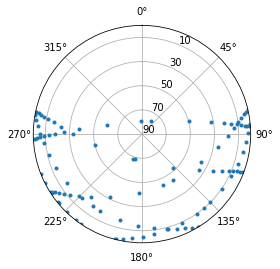

In [7]:
plot_polar(azimuths,elevations)